# 04 - Advanced Forecasting Models

Implement advanced deep learning models not covered in class:
1. N-BEATS (Neural Basis Expansion Analysis for Time Series)
2. XGBoost (Tree-based approach)
3. Model comparison and analysis

In [1]:
import sys
sys.path.append('..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import yaml

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 6)

from src.evaluation.metrics import regression_metrics
from src.utils.seed import set_seed

with open('../config/project.yaml') as f:
    config = yaml.safe_load(f)

set_seed(config['random_seed'])
print('Setup complete')

Setup complete


## 1. Load Data

In [2]:
data_dir = Path('../data/processed')
train_df = pd.read_parquet(data_dir / 'train.parquet')
val_df = pd.read_parquet(data_dir / 'val.parquet')
test_df = pd.read_parquet(data_dir / 'test.parquet')

target = config['project']['target_variable']
print(f'Data loaded. Target: {target}')
print(f'Train: {train_df.shape}, Val: {val_df.shape}, Test: {test_df.shape}')

Data loaded. Target: Global_active_power
Train: (1292, 46), Val: (60, 46), Test: (60, 46)


## 2. XGBoost Model

Gradient boosted trees with lag and rolling features.

In [3]:
# Install required packages
%pip install xgboost lightgbm

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

# Prepare features
feature_cols = [col for col in train_df.columns if col not in [target, 'is_outlier']]
print(f'Using {len(feature_cols)} features')

# Handle NaN values
X_train = train_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
y_train = train_df[target]

X_val = val_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
y_val = val_df[target]

X_test = test_df[feature_cols].fillna(method='ffill').fillna(method='bfill')
y_test = test_df[target]

print(f'Training XGBoost...')
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=config['random_seed'],
    n_jobs=-1,
    early_stopping_rounds=50
)

xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

print('XGBoost training complete')

Using 44 features
Training XGBoost...
XGBoost training complete
XGBoost training complete


In [5]:
# Predictions
xgb_pred_val = xgb_model.predict(X_val)
xgb_pred_test = xgb_model.predict(X_test)

# Metrics
xgb_metrics_val = regression_metrics(y_val, xgb_pred_val)
xgb_metrics_test = regression_metrics(y_test, xgb_pred_test)

print('XGBoost - Validation:')
print(xgb_metrics_val)
print('\nXGBoost - Test:')
print(xgb_metrics_test)

results = {'xgboost': {'val': xgb_metrics_val, 'test': xgb_metrics_test}}

XGBoost - Validation:
{'mae': 0.00871924790665231, 'rmse': 0.011557157756562086, 'mape': 1.1704280874066475, 'r2': 0.9983827868821825}

XGBoost - Test:
{'mae': 0.008565864363343256, 'rmse': 0.012455365739509327, 'mape': 0.7730549358808664, 'r2': 0.9978176474472071}


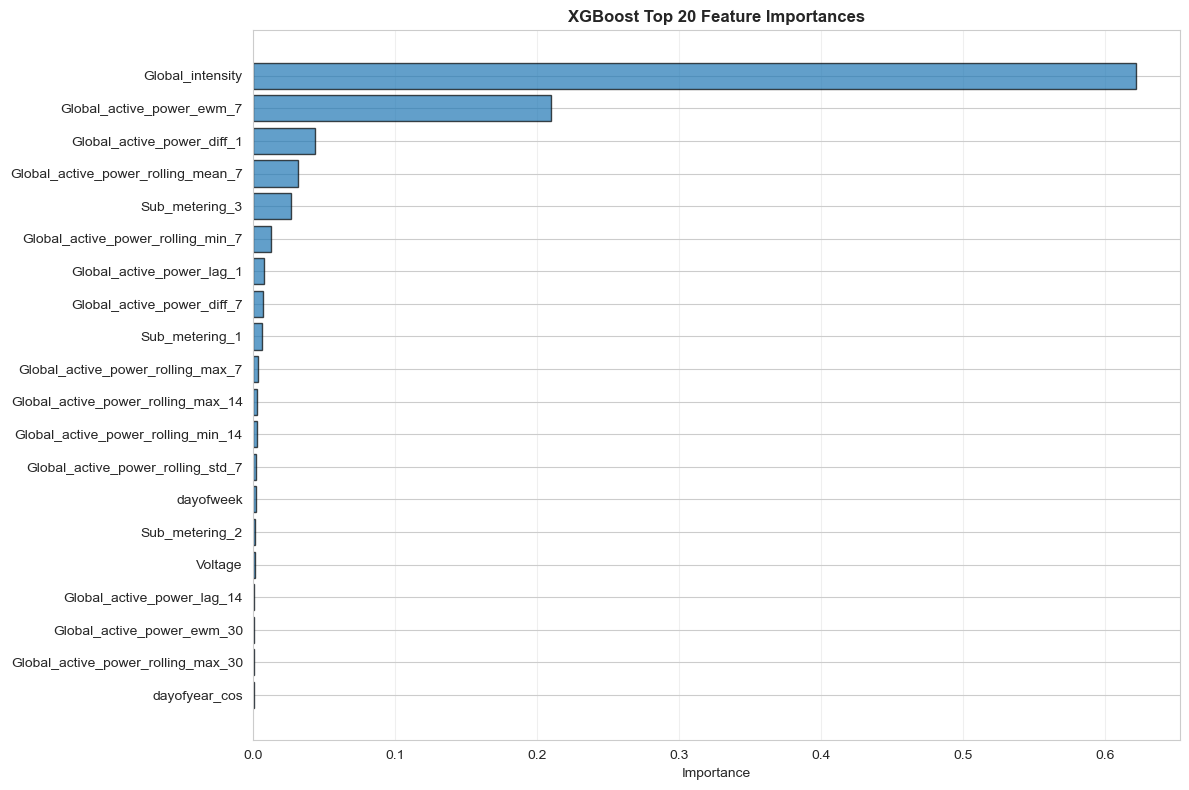

In [6]:
# Feature importance
importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False).head(20)

fig, ax = plt.subplots(figsize=(12, 8))
ax.barh(importance['feature'], importance['importance'], alpha=0.7, edgecolor='black')
ax.set_xlabel('Importance')
ax.set_title('XGBoost Top 20 Feature Importances', fontsize=12, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('../reports/xgboost_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

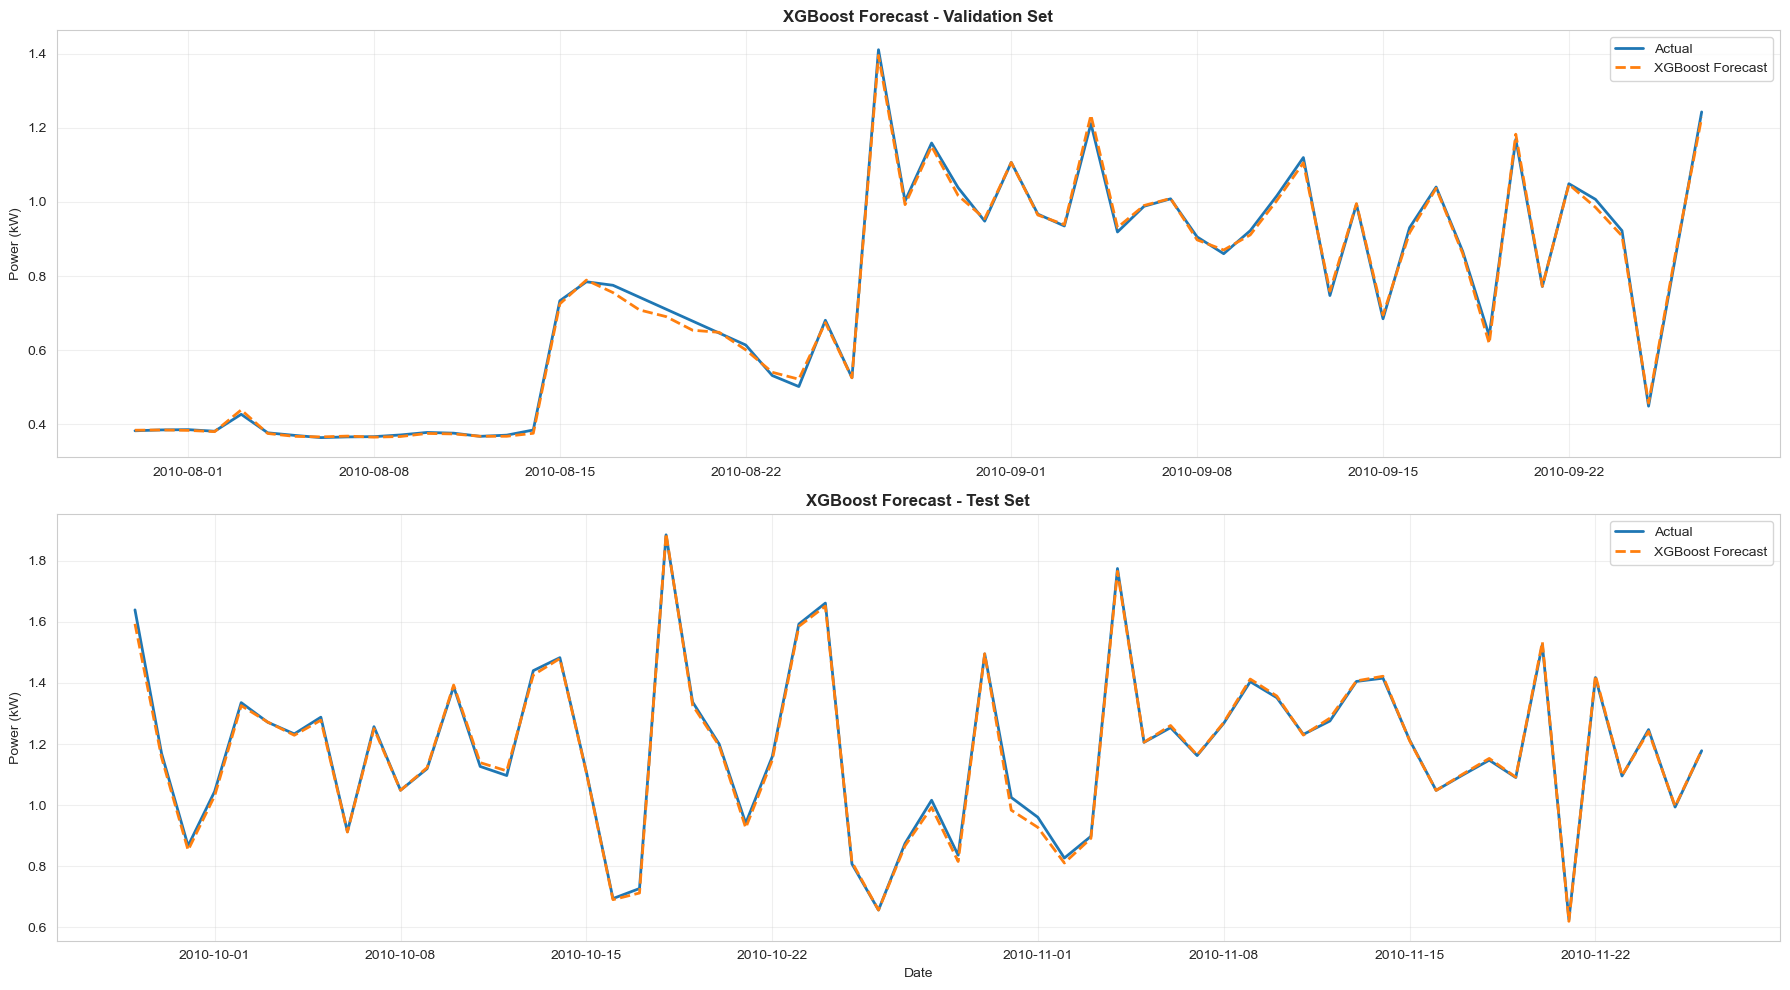

In [7]:
# Visualize predictions
fig, axes = plt.subplots(2, 1, figsize=(18, 10))

axes[0].plot(val_df.index, y_val, label='Actual', linewidth=2)
axes[0].plot(val_df.index, xgb_pred_val, label='XGBoost Forecast', linewidth=2, linestyle='--')
axes[0].set_title('XGBoost Forecast - Validation Set', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Power (kW)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_df.index, y_test, label='Actual', linewidth=2)
axes[1].plot(test_df.index, xgb_pred_test, label='XGBoost Forecast', linewidth=2, linestyle='--')
axes[1].set_title('XGBoost Forecast - Test Set', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Power (kW)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/xgboost_forecast.png', dpi=300, bbox_inches='tight')
plt.show()

## 3. LightGBM Model

Another gradient boosting variant for comparison.

In [8]:
import lightgbm as lgb

print('Training LightGBM...')
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=5,
    min_child_samples=20,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=config['random_seed'],
    n_jobs=-1,
    verbose=-1
)

lgb_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    callbacks=[lgb.early_stopping(50), lgb.log_evaluation(0)]
)

print('LightGBM training complete')

Training LightGBM...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[82]	valid_0's l2: 0.00049598
LightGBM training complete
Early stopping, best iteration is:
[82]	valid_0's l2: 0.00049598
LightGBM training complete


In [9]:
# Predictions
lgb_pred_val = lgb_model.predict(X_val)
lgb_pred_test = lgb_model.predict(X_test)

# Metrics
lgb_metrics_val = regression_metrics(y_val, lgb_pred_val)
lgb_metrics_test = regression_metrics(y_test, lgb_pred_test)

print('LightGBM - Validation:')
print(lgb_metrics_val)
print('\nLightGBM - Test:')
print(lgb_metrics_test)

results['lightgbm'] = {'val': lgb_metrics_val, 'test': lgb_metrics_test}

LightGBM - Validation:
{'mae': 0.015251399473494123, 'rmse': 0.02227061690282827, 'mape': 2.039021367454832, 'r2': 0.9939947697028689}

LightGBM - Test:
{'mae': 0.013560149462925173, 'rmse': 0.019133279961305514, 'mape': 1.2310582768332194, 'r2': 0.9948501948880157}


## 4. Random Forest

Ensemble of decision trees.

In [10]:
from sklearn.ensemble import RandomForestRegressor

print('Training Random Forest...')
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=config['random_seed'],
    n_jobs=-1
)

rf_model.fit(X_train, y_train)
print('Random Forest training complete')

# Predictions
rf_pred_val = rf_model.predict(X_val)
rf_pred_test = rf_model.predict(X_test)

# Metrics
rf_metrics_val = regression_metrics(y_val, rf_pred_val)
rf_metrics_test = regression_metrics(y_test, rf_pred_test)

print('Random Forest - Validation:')
print(rf_metrics_val)
print('\nRandom Forest - Test:')
print(rf_metrics_test)

results['random_forest'] = {'val': rf_metrics_val, 'test': rf_metrics_test}

Training Random Forest...
Random Forest training complete
Random Forest - Validation:
{'mae': 0.007553354531125294, 'rmse': 0.010589373820332967, 'mape': 1.0174137786878459, 'r2': 0.9986422940163099}

Random Forest - Test:
{'mae': 0.010562906948648313, 'rmse': 0.013634818052108855, 'mape': 1.0037929474670275, 'r2': 0.9973847655081438}
Random Forest training complete
Random Forest - Validation:
{'mae': 0.007553354531125294, 'rmse': 0.010589373820332967, 'mape': 1.0174137786878459, 'r2': 0.9986422940163099}

Random Forest - Test:
{'mae': 0.010562906948648313, 'rmse': 0.013634818052108855, 'mape': 1.0037929474670275, 'r2': 0.9973847655081438}


## 5. SARIMAX (with Exogenous Features)

Statistical seasonal ARIMA with exogenous regressors taken from the engineered feature set. Trains on train, validates on val, then retrains on train+val to forecast test.

In [11]:
# SARIMAX with exogenous features
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Use a SAFE subset of exogenous regressors to avoid leakage:
# - keep calendar/time features (e.g., hour, day_of_week, month, is_weekend, etc.)
# - drop any features likely derived from the target (lag/rolling/diff/ewm/shifts)
# - also drop anything containing the target name just in case
_leak_patterns = (
    'lag', 'rolling', 'expanding', 'ewm', 'diff', 'shift', 'ma', 'ewma', 'cumsum'
)
exog_cols = []
for c in feature_cols:
    cname = c.lower()
    if (target.lower() in cname) or any(p in cname for p in _leak_patterns):
        continue
    exog_cols.append(c)

if len(exog_cols) == 0:
    print('No safe exogenous columns detected; proceeding without exogenous regressors.')

# Ensure all exogenous regressors are numeric and aligned across splits
# Convert any non-numeric to NaN, then fill and cast to float
def to_numeric_exog(df, cols):
    if not cols:
        return None
    exog = df[cols].apply(pd.to_numeric, errors='coerce')
    exog = exog.fillna(method='ffill').fillna(method='bfill').fillna(0.0)
    return exog.astype(float)

X_train_exog = to_numeric_exog(X_train, exog_cols)
X_val_exog = to_numeric_exog(X_val, exog_cols)
X_test_exog = to_numeric_exog(X_test, exog_cols)

# Basic SARIMAX configuration; adjust if you maintain config in YAML
order = (1, 1, 1)
seasonal_order = (0, 1, 1, 7)

print('Training SARIMAX (safe exogenous)...')
sarimax_model = SARIMAX(
    y_train.astype(float),
    exog=X_train_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_fit = sarimax_model.fit(disp=False)

sarimax_val_pred = sarimax_fit.get_forecast(steps=len(y_val), exog=X_val_exog).predicted_mean.values

# Retrain on train+val for test forecast
y_train_val = pd.concat([y_train, y_val])
X_train_val_exog = None if X_train_exog is None else pd.concat([X_train_exog, X_val_exog])

sarimax_full = SARIMAX(
    y_train_val.astype(float),
    exog=X_train_val_exog,
    order=order,
    seasonal_order=seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
).fit(disp=False)

sarimax_test_pred = sarimax_full.get_forecast(steps=len(y_test), exog=X_test_exog).predicted_mean.values

sarimax_metrics_val = regression_metrics(y_val.values, sarimax_val_pred)
sarimax_metrics_test = regression_metrics(y_test.values, sarimax_test_pred)

print('SARIMAX - Validation:', sarimax_metrics_val)
print('SARIMAX - Test:', sarimax_metrics_test)

results['sarimax'] = {'val': sarimax_metrics_val, 'test': sarimax_metrics_test}

Training SARIMAX (safe exogenous)...


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, 

SARIMAX - Validation: {'mae': 0.00905125940893381, 'rmse': 0.011022275071458549, 'mape': 1.2564134827517563, 'r2': 0.9985290169699059}
SARIMAX - Test: {'mae': 0.013980610641395974, 'rmse': 0.01771418903707307, 'mape': 1.2202982417168908, 'r2': 0.9955857747419046}


## 6. N-BEATS (Neural Basis Expansion Analysis for Time Series)

A deep learning model designed specifically for univariate time series forecasting using backward and forward basis expansions.

In [12]:
# N-BEATS via darts with sklearn compatibility patches; skip gracefully if still unavailable.
import sys, subprocess, warnings, importlib

# Ensure darts is installed (without importing it yet to avoid early import errors)
if importlib.util.find_spec("darts") is None:
    try:
        print("Installing u8darts ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "u8darts", "--quiet"]) 
    except Exception as _install_err:
        print(f"Skipping N-BEATS: could not install darts (u8darts). Error: {_install_err}")

# Ensure deep learning deps for darts are installed
try:
    import pytorch_lightning  # noqa: F401
except Exception:
    try:
        print("Installing pytorch-lightning and torchmetrics ...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pytorch-lightning", "torchmetrics", "--quiet"]) 
    except Exception as _pl_err:
        print(f"Warning: could not install pytorch-lightning deps: {_pl_err}")

# Patch sklearn for darts compatibility
try:
    import sklearn.utils as _sku
    # get_tags fallback on sklearn.utils
    if not hasattr(_sku, "get_tags"):
        warnings.warn("Patching sklearn.utils.get_tags for darts compatibility")
        def _get_tags(estimator):
            if hasattr(estimator, "get_tags"):
                return estimator.get_tags()
            return {}
        _sku.get_tags = _get_tags  # type: ignore[attr-defined]

    # validate_data fallback (import location used by some darts modules)
    import sklearn.utils.validation as _skv
    if not hasattr(_skv, "validate_data"):
        warnings.warn("Patching sklearn.utils.validation.validate_data for darts compatibility")
        def _validate_data(X=None, *args, **kwargs):
            # Minimal passthrough; darts should not rely on strict checks for N-BEATS
            return X
        _skv.validate_data = _validate_data  # type: ignore[attr-defined]

    # get_tags fallback on sklearn.utils._tags
    try:
        import sklearn.utils._tags as _sktags  # type: ignore
        if not hasattr(_sktags, "get_tags"):
            warnings.warn("Patching sklearn.utils._tags.get_tags for darts compatibility")
            def _get_tags_internal(estimator):
                if hasattr(estimator, "get_tags"):
                    return estimator.get_tags()
                return {}
            _sktags.get_tags = _get_tags_internal  # type: ignore[attr-defined]
    except Exception as _e:
        print(f"Warning: could not patch sklearn.utils._tags: {_e}")
except Exception as _patch_err:
    print(f"Warning: could not fully patch sklearn compatibility: {_patch_err}")

try:
    import numpy as np
    import torch
    from darts import TimeSeries
    from darts.models import NBEATSModel
    from darts.utils.missing_values import fill_missing_values

    # Force float32 and CPU to avoid macOS MPS float64 limitations
    torch.set_default_dtype(torch.float32)
    pl_kwargs = {"accelerator": "cpu"}

    # Build univariate series from the target, casting to float32
    concat_df = pd.concat([train_df, val_df, test_df]).copy()
    concat_df[target] = pd.to_numeric(concat_df[target], errors='coerce').astype(np.float32)

    series_full = TimeSeries.from_dataframe(
        concat_df,
        time_col=None,  # use index
        value_cols=target,
    )
    try:
        series_full = series_full.astype(np.float32)
    except Exception:
        # some versions may not have astype; already float32 from df
        pass
    series_full = fill_missing_values(series_full)

    # Split into train/val/test by length
    train_len = len(train_df)
    val_len = len(val_df)

    train_series = series_full[:train_len]
    val_series = series_full[train_len:train_len+val_len]
    test_series = series_full[train_len+val_len:]

    print('Training N-BEATS...')
    nbeats = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=val_len,
        n_epochs=50,
        random_state=config['random_seed'],
        pl_trainer_kwargs=pl_kwargs
    )

    nbeats.fit(train_series, verbose=False)
    val_forecast = nbeats.predict(n=val_len)

    nbeats_val_pred = val_forecast.values().flatten().astype(np.float32)
    nbeats_val_true = val_series.values().flatten().astype(np.float32)

    nbeats_metrics_val = regression_metrics(nbeats_val_true, nbeats_val_pred)
    print('N-BEATS - Validation:', nbeats_metrics_val)

    # Retrain on train+val, predict test
    nbeats_test = NBEATSModel(
        input_chunk_length=30,
        output_chunk_length=len(test_df),
        n_epochs=50,
        random_state=config['random_seed'],
        pl_trainer_kwargs=pl_kwargs
    )

    nbeats_test.fit(series_full[:-len(test_df)], verbose=False)
    test_forecast = nbeats_test.predict(n=len(test_df))

    nbeats_test_pred = test_forecast.values().flatten().astype(np.float32)
    nbeats_test_true = test_series.values().flatten().astype(np.float32)

    nbeats_metrics_test = regression_metrics(nbeats_test_true, nbeats_test_pred)
    print('N-BEATS - Test:', nbeats_metrics_test)

    results['n_beats'] = {'val': nbeats_metrics_val, 'test': nbeats_metrics_test}
except Exception as e:
    print(f"Skipping N-BEATS due to error: {e}")

The StatsForecast module could not be imported. To enable support for the AutoARIMA, AutoETS and Croston models, please consider installing it.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Training N-BEATS...


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


N-BEATS - Validation: {'mae': 0.21253138780593872, 'rmse': 0.26910575507933776, 'mape': 30.78567683696747, 'r2': 0.12317860126495361}


`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

N-BEATS - Test: {'mae': 0.4983671307563782, 'rmse': 0.5797271180302848, 'mape': 39.43488299846649, 'r2': -3.7278008460998535}


## 5. Model Comparison

We aggregate validation and test metrics across all advanced models, rank them (lower RMSE is better), and save:
- reports/advanced_models_comparison.csv (raw table)
- reports/advanced_models_comparison_ranked.csv (with ranks and average rank)
- reports/figures/advanced_models_comparison.png (bar chart of RMSE by model)

This helps quickly identify the best-performing model(s) and compare validation vs. test performance.


Advanced Model Comparison (ranked by RMSE):
        Model  Val MAE  Val RMSE  Val MAPE   Val R²  Test MAE  Test RMSE  Test MAPE   Test R²  Val Rank  Test Rank  Avg Rank
Random Forest 0.007553  0.010589  1.017414 0.998642  0.010563   0.013635   1.003793  0.997385       1.0        2.0       1.5
      XGBoost 0.008719  0.011557  1.170428 0.998383  0.008566   0.012455   0.773055  0.997818       3.0        1.0       2.0
      SARIMAX 0.009051  0.011022  1.256413 0.998529  0.013981   0.017714   1.220298  0.995586       2.0        3.0       2.5
     LightGBM 0.015251  0.022271  2.039021 0.993995  0.013560   0.019133   1.231058  0.994850       4.0        4.0       4.0
      N-BEATS 0.212531  0.269106 30.785677 0.123179  0.498367   0.579727  39.434883 -3.727801       5.0        5.0       5.0


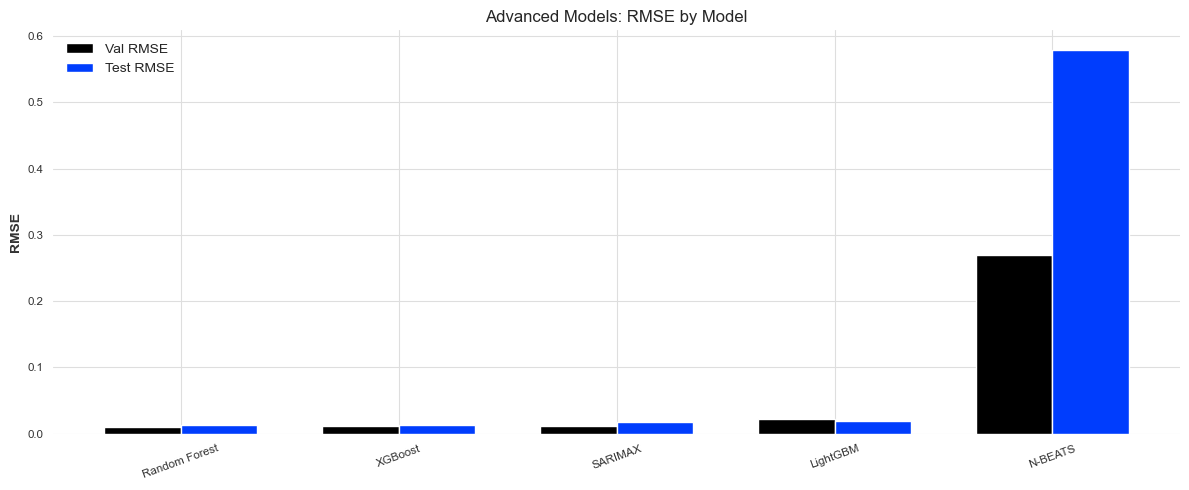


Results saved to:
- ../reports/advanced_models_comparison.csv
- ../reports/advanced_models_comparison_ranked.csv
- ../reports/figures/advanced_models_comparison.png


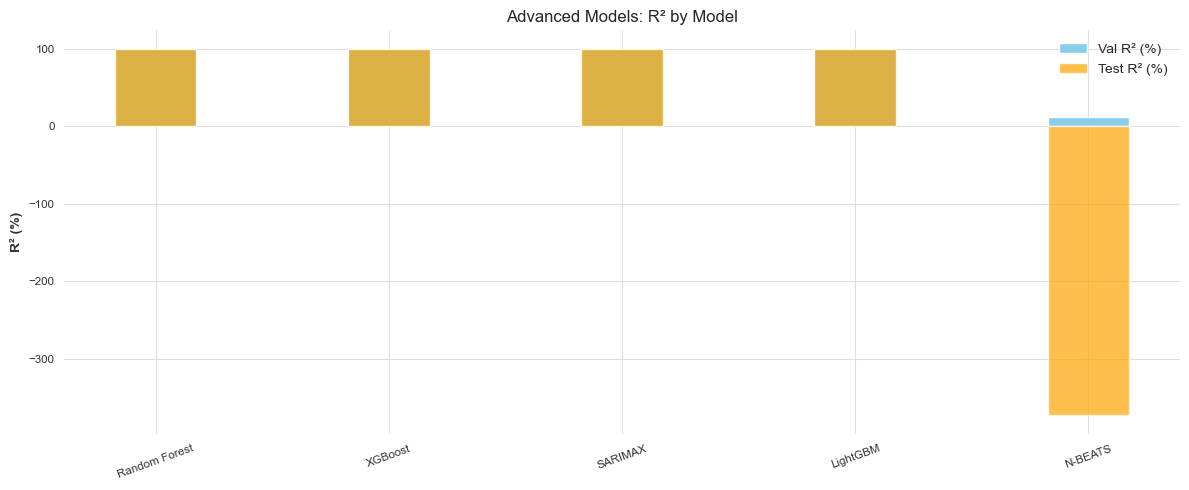

In [17]:
# Create comparison table
comparison_data = []
# Friendly display names for models
_display_name = {
    'xgboost': 'XGBoost',
    'lightgbm': 'LightGBM',
    'random_forest': 'Random Forest',
    'sarimax': 'SARIMAX',
    'n_beats': 'N-BEATS',
}
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': _display_name.get(model_name, model_name.replace('_', '-').upper()),
        'Val MAE': metrics['val']['mae'],
        'Val RMSE': metrics['val']['rmse'],
        'Val MAPE': metrics['val']['mape'],
        'Val R²': metrics['val']['r2'],
        'Test MAE': metrics['test']['mae'],
        'Test RMSE': metrics['test']['rmse'],
        'Test MAPE': metrics['test']['mape'],
        'Test R²': metrics['test']['r2']
    })

comparison_df = pd.DataFrame(comparison_data).round(6)

# Ranking (lower RMSE is better)
comparison_df['Val Rank'] = comparison_df['Val RMSE'].rank(method='min')
comparison_df['Test Rank'] = comparison_df['Test RMSE'].rank(method='min')
comparison_df['Avg Rank'] = (comparison_df['Val Rank'] + comparison_df['Test Rank']) / 2
comparison_df = comparison_df.sort_values(['Avg Rank', 'Test RMSE']).reset_index(drop=True)

print('\nAdvanced Model Comparison (ranked by RMSE):')
print(comparison_df.to_string(index=False))

# Save tables
reports_dir = Path('../reports')
fig_dir = reports_dir / 'figures'
fig_dir.mkdir(parents=True, exist_ok=True)

comparison_df.to_csv(reports_dir / 'advanced_models_comparison_ranked.csv', index=False)
comparison_df.round(4).to_csv(reports_dir / 'advanced_models_comparison.csv', index=False)

# Plot RMSEs
plt.figure(figsize=(12, 5))
x = np.arange(len(comparison_df))
width = 0.35
plt.bar(x - width/2, comparison_df['Val RMSE'], width=width, label='Val RMSE')
plt.bar(x + width/2, comparison_df['Test RMSE'], width=width, label='Test RMSE')
plt.xticks(x, comparison_df['Model'], rotation=20)
plt.ylabel('RMSE')
plt.title('Advanced Models: RMSE by Model')
plt.legend()
plt.tight_layout()
plt.savefig(fig_dir / 'advanced_models_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print('\nResults saved to:')
print(f"- {reports_dir / 'advanced_models_comparison.csv'}")
print(f"- {reports_dir / 'advanced_models_comparison_ranked.csv'}")
print(f"- {fig_dir / 'advanced_models_comparison.png'}")

## Save trained models

Persist trained models and artifacts to the models directory for reuse.

In [14]:
from pathlib import Path
import joblib
import json
import numpy as np

models_dir = Path('../models')
models_dir.mkdir(parents=True, exist_ok=True)

from datetime import datetime
run_dir = models_dir / f"advanced_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
run_dir.mkdir(exist_ok=True)

meta = {
    'created_at': datetime.now().isoformat(timespec='seconds'),
    'notebook': '04_advanced_model.ipynb',
    'target': target,
}

# Helper to JSON-serialize numpy types
def _to_jsonable(obj):
    if isinstance(obj, (np.floating,)):
        return float(obj)
    if isinstance(obj, (np.integer,)):
        return int(obj)
    if isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    return obj

# XGBoost
try:
    if 'xgb_model' in globals():
        xgb_path = run_dir / 'xgboost_model.json'
        # Use XGBoost's own save_model for portability
        xgb_model.save_model(xgb_path.as_posix())
        print(f"Saved XGBoost model to {xgb_path}")
    else:
        print('XGBoost model not found; skipping save.')
except Exception as e:
    print(f'Warning: failed to save XGBoost model: {e}')

# LightGBM
try:
    if 'lgb_model' in globals():
        lgb_path = run_dir / 'lightgbm_model.txt'
        lgb_model.booster_.save_model(lgb_path.as_posix())
        print(f"Saved LightGBM model to {lgb_path}")
    else:
        print('LightGBM model not found; skipping save.')
except Exception as e:
    print(f'Warning: failed to save LightGBM model: {e}')

# Random Forest
try:
    if 'rf_model' in globals():
        rf_path = run_dir / 'random_forest.joblib'
        joblib.dump(rf_model, rf_path)
        print(f"Saved Random Forest to {rf_path}")
    else:
        print('Random Forest model not found; skipping save.')
except Exception as e:
    print(f'Warning: failed to save Random Forest: {e}')

# SARIMAX (train and full)
try:
    if 'sarimax_fit' in globals():
        sarimax_path = run_dir / 'sarimax_fit.joblib'
        joblib.dump(sarimax_fit, sarimax_path)
        print(f"Saved SARIMAX fit to {sarimax_path}")
    else:
        print('SARIMAX fit not found; skipping save.')

    if 'sarimax_full' in globals():
        sarimax_full_path = run_dir / 'sarimax_full.joblib'
        joblib.dump(sarimax_full, sarimax_full_path)
        print(f"Saved SARIMAX full model to {sarimax_full_path}")
except Exception as e:
    print(f'Warning: failed to save SARIMAX models: {e}')

# N-BEATS via darts
try:
    if 'nbeats' in globals():
        nbeats_dir = run_dir / 'nbeats_val'
        nbeats.save(nbeats_dir.as_posix())
        print(f"Saved N-BEATS validation model to {nbeats_dir}")
    else:
        print('N-BEATS validation model not found; skipping save.')
    if 'nbeats_test' in globals():
        nbeats_test_dir = run_dir / 'nbeats_test'
        nbeats_test.save(nbeats_test_dir.as_posix())
        print(f"Saved N-BEATS test model to {nbeats_test_dir}")
    else:
        print('N-BEATS test model not found; skipping save.')
except Exception as e:
    print(f'Warning: failed to save N-BEATS models: {e}')

# Save feature columns used by tree models for clarity
try:
    feature_cols_path = run_dir / 'feature_cols.txt'
    with open(feature_cols_path, 'w') as f:
        for c in feature_cols:
            f.write(str(c) + '\n')
    print(f"Saved feature column list to {feature_cols_path}")
except Exception as e:
    print(f'Warning: failed to save feature columns: {e}')

# Save comparison metrics table and raw results dict if available
try:
    if 'comparison_df' in globals():
        comp_csv_path = run_dir / 'advanced_models_comparison_ranked.csv'
        comparison_df.to_csv(comp_csv_path, index=False)
        print(f"Saved ranked comparison table to {comp_csv_path}")
    if 'results' in globals():
        results_path = run_dir / 'metrics.json'
        with open(results_path, 'w') as f:
            json.dump(results, f, indent=2, default=_to_jsonable)
        print(f"Saved metrics to {results_path}")
except Exception as e:
    print(f'Warning: failed to save metrics/comparison: {e}')

# Save summary metadata
try:
    meta_path = run_dir / 'metadata.json'
    with open(meta_path, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved metadata to {meta_path}")
except Exception as e:
    print(f'Warning: failed to save metadata: {e}')

# Determine and record the best model
try:
    import pandas as _pd
    # Build a lightweight comparison if not already available
    if 'comparison_df' not in globals() and 'results' in globals():
        rows = []
        name_map = {
            'xgboost': 'XGBoost',
            'lightgbm': 'LightGBM',
            'random_forest': 'Random Forest',
            'sarimax': 'SARIMAX',
            'n_beats': 'N-BEATS',
        }
        for k, m in results.items():
            rows.append({
                'Model': name_map.get(k, k),
                'key': k,
                'Val RMSE': m['val'].get('rmse', float('inf')),
                'Test RMSE': m['test'].get('rmse', float('inf'))
            })
        comparison_df = _pd.DataFrame(rows)
    
    best_row = None
    if 'comparison_df' in globals() and not comparison_df.empty:
        # Prefer Test RMSE; fall back to Val RMSE if needed
        if 'Test RMSE' in comparison_df.columns and comparison_df['Test RMSE'].notna().any():
            best_row = comparison_df.loc[comparison_df['Test RMSE'].idxmin()]
        else:
            best_row = comparison_df.loc[comparison_df['Val RMSE'].idxmin()]
    
    # Map model key to saved artifact, if available
    artifact_map = {}
    if 'xgb_path' in locals():
        artifact_map['xgboost'] = str(xgb_path)
    if 'lgb_path' in locals():
        artifact_map['lightgbm'] = str(lgb_path)
    if 'rf_path' in locals():
        artifact_map['random_forest'] = str(rf_path)
    if 'sarimax_full_path' in locals():
        artifact_map['sarimax'] = str(sarimax_full_path)
    elif 'sarimax_path' in locals():
        artifact_map['sarimax'] = str(sarimax_path)
    if 'nbeats_test_dir' in locals():
        artifact_map['n_beats'] = str(nbeats_test_dir)
    elif 'nbeats_dir' in locals():
        artifact_map['n_beats'] = str(nbeats_dir)
    
    best_info = {}
    if best_row is not None:
        # Recover internal key from display name when possible
        key_by_display = {
            'XGBoost': 'xgboost',
            'LightGBM': 'lightgbm',
            'Random Forest': 'random_forest',
            'SARIMAX': 'sarimax',
            'N-BEATS': 'n_beats',
        }
        best_display = str(best_row.get('Model', ''))
        best_key = key_by_display.get(best_display, None)
        # If we don't have the display mapping, infer by matching results keys to display
        if best_key is None and 'results' in globals():
            for k in results.keys():
                if k.replace('_','-').lower() in best_display.replace('_','-').lower():
                    best_key = k
                    break
        best_info = {
            'model_display': best_display,
            'model_key': best_key,
            'val_rmse': float(best_row.get('Val RMSE', float('nan'))),
            'test_rmse': float(best_row.get('Test RMSE', float('nan'))),
            'artifact_path': artifact_map.get(best_key) if best_key else None,
            'run_dir': str(run_dir),
            'created_at': meta['created_at']
        }
        print(f"Best model (advanced): {best_info['model_display']} | Val RMSE: {best_info['val_rmse']:.4f} | Test RMSE: {best_info['test_rmse']:.4f}")
    else:
        print('Could not determine best model; comparison table missing or empty.')
        best_info = {
            'note': 'best model could not be determined',
            'run_dir': str(run_dir),
            'created_at': meta['created_at']
        }
    
    # Persist best model info
    best_path = run_dir / 'best_model.json'
    with open(best_path, 'w') as f:
        json.dump(best_info, f, indent=2, default=_to_jsonable)
    print(f"Saved best model info to {best_path}")
    
    # Also write/update a pointer file at models root for convenience
    try:
        root_best_path = models_dir / 'best_advanced.json'
        with open(root_best_path, 'w') as f:
            json.dump(best_info, f, indent=2, default=_to_jsonable)
        print(f"Updated {root_best_path}")
    except Exception as _e:
        print(f"Warning: could not update models/best_advanced.json: {_e}")
except Exception as e:
    print(f'Warning: failed to determine/save best model info: {e}')

Saved XGBoost model to ../models/advanced_20251008_141626/xgboost_model.json
Saved LightGBM model to ../models/advanced_20251008_141626/lightgbm_model.txt
Saved Random Forest to ../models/advanced_20251008_141626/random_forest.joblib
Saved SARIMAX fit to ../models/advanced_20251008_141626/sarimax_fit.joblib
Saved SARIMAX full model to ../models/advanced_20251008_141626/sarimax_full.joblib
Saved N-BEATS validation model to ../models/advanced_20251008_141626/nbeats_val
Saved N-BEATS test model to ../models/advanced_20251008_141626/nbeats_test
Saved feature column list to ../models/advanced_20251008_141626/feature_cols.txt
Saved ranked comparison table to ../models/advanced_20251008_141626/advanced_models_comparison_ranked.csv
Saved metrics to ../models/advanced_20251008_141626/metrics.json
Saved metadata to ../models/advanced_20251008_141626/metadata.json
Best model (advanced): XGBoost | Val RMSE: 0.0116 | Test RMSE: 0.0125
Saved best model info to ../models/advanced_20251008_141626/best